# WellCo Churn Model — Evaluation & Feature Assessment

## Why this notebook exists
The assignment goal is to **rank members for outreach** to reduce churn and to **choose an optimal outreach size** (how many members to contact).

This notebook does three things:
- **Feature assessment**: Which features are most predictive? Are there redundant signals? Do features behave as expected?
- **Model performance**: How well does the ranking work? Is the model calibrated? Where does it fail?
- **Business application**: Given model scores, how should we prioritize outreach? What's the expected lift?

Client context (from `wellco_client_brief.txt`): cardiometabolic focus; ICD codes of interest include **E11.9**, **I10**, **Z71.3**.

## What I'm looking for in evaluation
- Do the most important features align with domain intuition (engagement, recency, clinical signals)?
- Is the model properly ranking high-risk members (discrimination via AUC)?
- Are predicted probabilities meaningful (calibration)?
- At different outreach budgets, what's the expected churn capture rate (lift)?
- Any red flags: leakage, overfit, unstable features.


In [ ]:
from __future__ import annotations

import json
import sys
from dataclasses import dataclass
from pathlib import Path

import joblib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 4)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [86]:
def find_repo_root(start: Path | None = None) -> Path:
    """Find the repo root by walking up until we see a `data/` directory."""
    here = (start or Path.cwd()).resolve()
    for p in [here, *here.parents]:
        if (p / "data").exists():
            return p
    raise FileNotFoundError("Could not find repo root (expected a `data/` directory).")


REPO_ROOT = find_repo_root()
DATA_DIR = REPO_ROOT / "data"
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"
ARTIFACTS_DIR = REPO_ROOT / "artifacts"

# Add repo root to path for imports (so we can import from src package)
sys.path.insert(0, str(REPO_ROOT))

REPO_ROOT, ARTIFACTS_DIR.exists()


(PosixPath('/Users/matansheffer/projects/ViMatanSheffer'), True)

In [87]:
# Load model artifacts
model = joblib.load(ARTIFACTS_DIR / "baseline_model.joblib")

with open(ARTIFACTS_DIR / "baseline_model_meta.json", "r") as f:
    model_meta = json.load(f)

test_preds = pd.read_csv(ARTIFACTS_DIR / "test_predictions.csv")

feature_cols = model_meta["feature_cols"]

print(f"Model: {type(model.named_steps['clf']).__name__}")
print(f"Test AUC-ROC: {model_meta['test_auc_roc']:.4f}")
print(f"Test AUC-PRC: {model_meta['test_auc_prc']:.4f}")
print(f"Number of features: {len(feature_cols)}")


Model: GradientBoostingClassifier
Test AUC-ROC: 0.6530
Test AUC-PRC: 0.3128
Number of features: 86


Takeaway: Baseline model achieves ~0.65 AUC-ROC with 86 features. This is a moderate signal — better than random, but there's room for improvement.


In [88]:
# Load raw data and rebuild features for deeper analysis
from src.data_io import load_tables
from src.features import FeatureConfig, build_member_features

train_tables = load_tables(TRAIN_DIR)
test_tables = load_tables(TEST_DIR)

feat_cfg = FeatureConfig()
train_obs_end = pd.to_datetime(model_meta["train_observation_end"])

X_train, y_train = build_member_features(train_tables, feat_cfg, reference_observation_end=train_obs_end)
X_test, y_test = build_member_features(test_tables, feat_cfg, reference_observation_end=train_obs_end)

print(f"Train: {X_train.shape[0]:,} members, {X_train.shape[1]} features")
print(f"Test: {X_test.shape[0]:,} members, {X_test.shape[1]} features")


Train: 10,000 members, 87 features
Test: 10,000 members, 87 features


## 1) Feature Assessment — Importance Analysis

First question: which features contribute most to the model's predictions?

For GradientBoosting, we can extract feature importances directly (based on split gain).


In [107]:
# Extract feature importances from the GradientBoosting classifier
clf = model.named_steps["clf"]
importances = clf.feature_importances_

# Create importance dataframe
importance_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False)

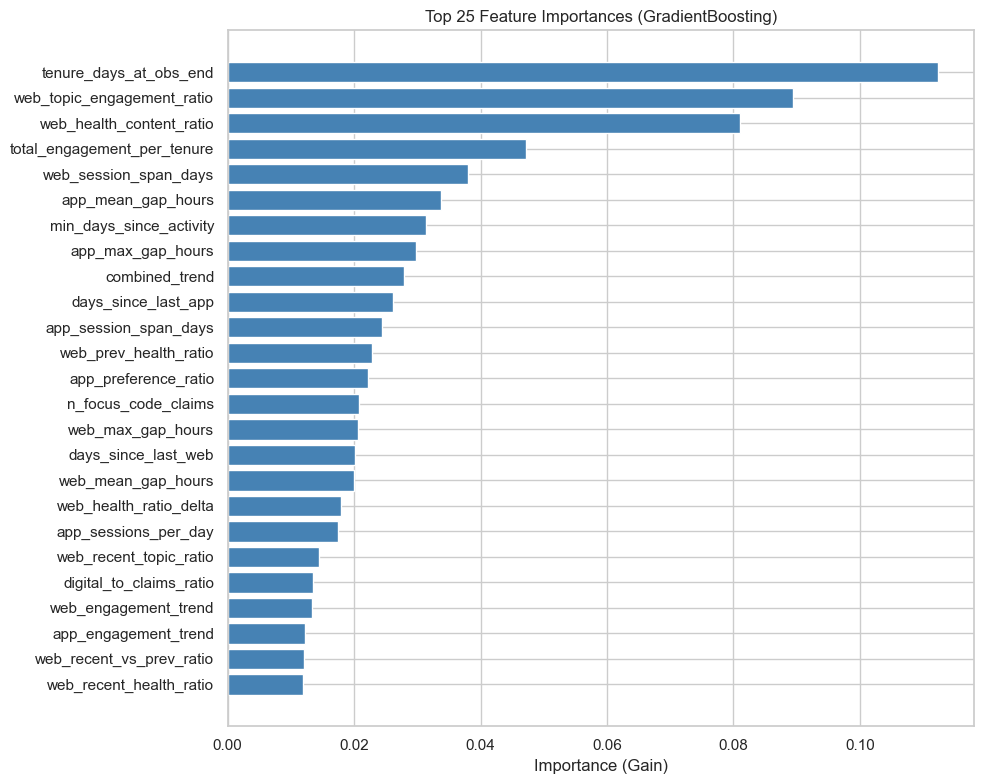

In [108]:
# Visualize top 25 features
top_n = 25
top_features = importance_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(top_n), top_features["importance"].values[::-1], color="steelblue")
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features["feature"].values[::-1])
ax.set_xlabel("Importance (Gain)")
ax.set_title(f"Top {top_n} Feature Importances (GradientBoosting)")
plt.tight_layout()
plt.show()


Takeaway: The top features should reveal what signals the model relies on most heavily.


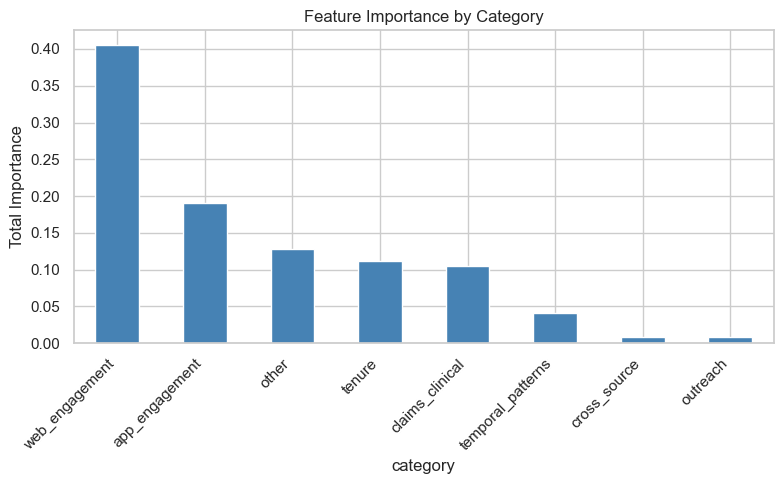

In [109]:
# Group features by category to see which domains contribute most
def categorize_feature(name: str) -> str:
    if name.startswith(("app_", "has_app")):
        return "app_engagement"
    elif name.startswith(("web_", "has_web", "visits")):
        return "web_engagement"
    elif name.startswith(("claim", "icd_", "has_icd", "n_claim", "n_unique_icd", "chronic", "n_focus", "n_acute", "n_chronic")):
        return "claims_clinical"
    elif name.startswith(("tenure", "is_new", "is_long", "signup")):
        return "tenure"
    elif name in ("outreach",):
        return "outreach"
    elif "trend" in name or "delta" in name or "ratio" in name:
        return "temporal_patterns"
    elif "channel" in name or "digital" in name or "preference" in name:
        return "cross_source"
    else:
        return "other"

importance_df["category"] = importance_df["feature"].apply(categorize_feature)
category_importance = importance_df.groupby("category")["importance"].sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 5))
category_importance.plot(kind="bar", ax=ax, color="steelblue")
ax.set_ylabel("Total Importance")
ax.set_title("Feature Importance by Category")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

Takeaway: Category-level importance shows which domains (app engagement, web engagement, claims, tenure) drive predictions most.


## 2) Feature Assessment — Correlation with Target

Beyond model importance, let's look at raw correlations with the churn label.
This helps validate that features behave as expected (e.g., more engagement → less churn).


In [110]:
# Compute Pearson correlation with target (on train set)
train_df = X_train.copy()
train_df["churn"] = y_train.values

# Only numeric features
numeric_features = [c for c in feature_cols if c in train_df.columns]
correlations = train_df[numeric_features + ["churn"]].corr()["churn"].drop("churn")

# Sort by absolute correlation
corr_df = correlations.abs().sort_values(ascending=False).to_frame("abs_correlation")
corr_df["correlation"] = correlations[corr_df.index]
corr_df["direction"] = np.where(corr_df["correlation"] > 0, "positive", "negative")


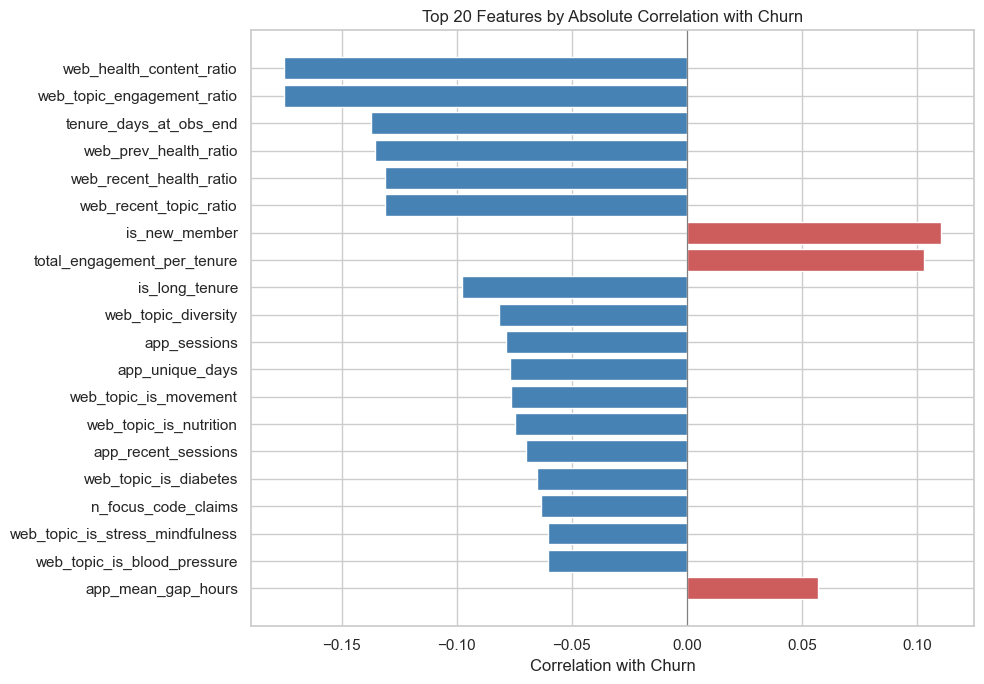

In [111]:
# Visualize top correlated features (positive and negative)
top_corr = corr_df.head(20).copy()
colors = ["indianred" if d == "positive" else "steelblue" for d in top_corr["direction"]]

fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(range(len(top_corr)), top_corr["correlation"].values[::-1], color=colors[::-1])
ax.set_yticks(range(len(top_corr)))
ax.set_yticklabels(top_corr.index.tolist()[::-1])
ax.axvline(0, color="gray", linewidth=0.8)
ax.set_xlabel("Correlation with Churn")
ax.set_title("Top 20 Features by Absolute Correlation with Churn")
plt.tight_layout()
plt.show()


Takeaway: Features with **negative** correlation (more engagement → less churn) should dominate if the model is sensible. Features with positive correlation (e.g., days_since_last_activity) indicate disengagement signals.


## 3) Feature Assessment — Distributions by Churn Status

For key features, let's visualize how distributions differ between churners and non-churners.
This helps build intuition about the signal strength.


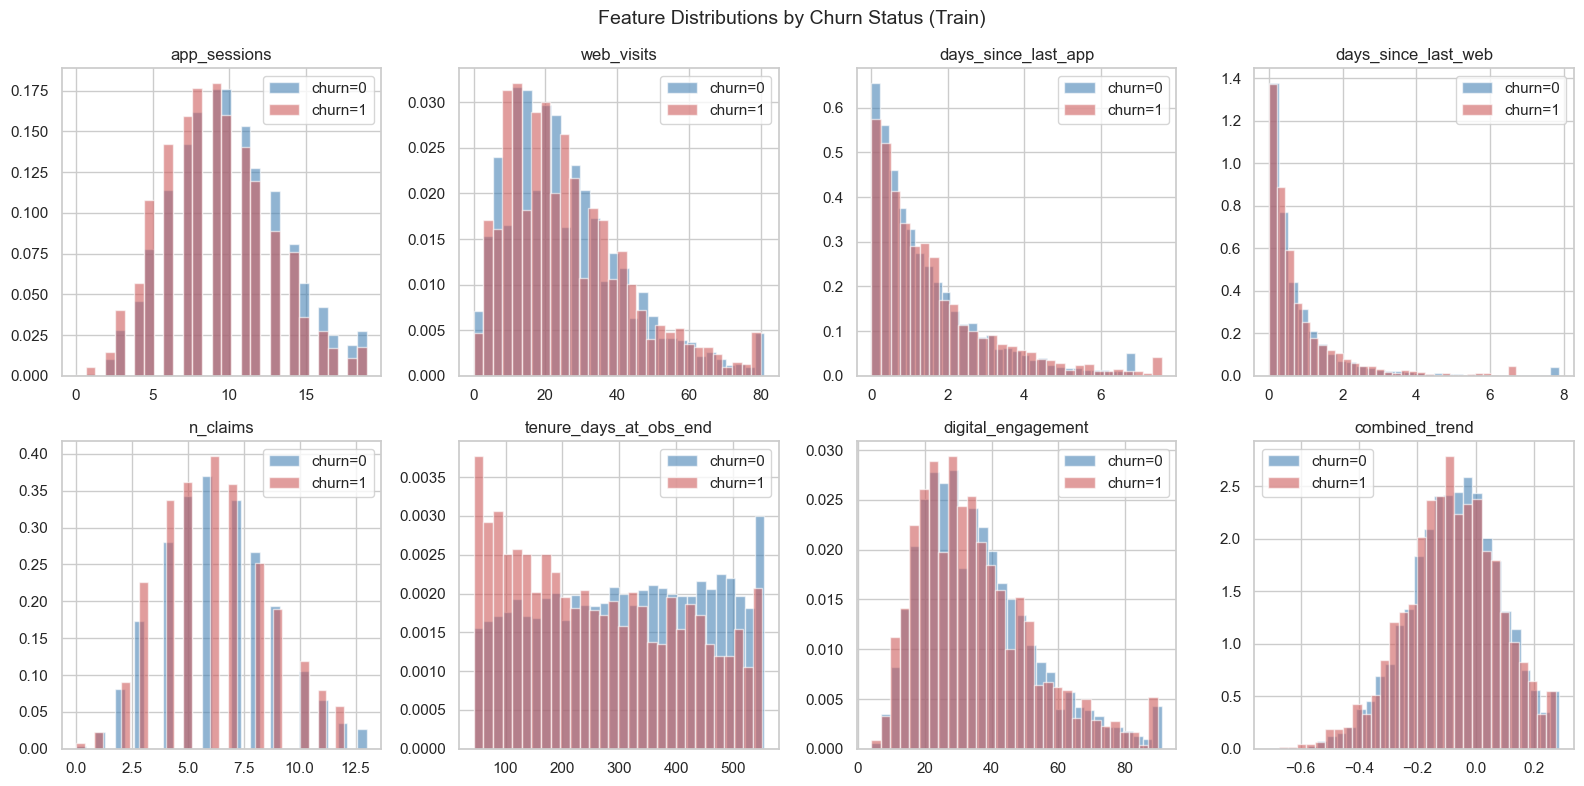

In [112]:
# Select key features to visualize
key_features = [
    "app_sessions",
    "web_visits",
    "days_since_last_app",
    "days_since_last_web",
    "n_claims",
    "tenure_days_at_obs_end",
    "digital_engagement",
    "combined_trend",
]

# Filter to features that exist
key_features = [f for f in key_features if f in train_df.columns]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, feat in enumerate(key_features):
    ax = axes[i]
    for label, color in [(0, "steelblue"), (1, "indianred")]:
        data = train_df.loc[train_df["churn"] == label, feat].dropna()
        # Clip extreme outliers for visualization
        clip_upper = data.quantile(0.99)
        data = data.clip(upper=clip_upper)
        ax.hist(data, bins=30, alpha=0.6, label=f"churn={label}", color=color, density=True)
    ax.set_title(feat)
    ax.legend()

# Hide unused subplots
for j in range(len(key_features), len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Feature Distributions by Churn Status (Train)", fontsize=14)
plt.tight_layout()
plt.show()


Takeaway: Visual separation between churn groups indicates predictive power. Features where distributions overlap heavily provide weaker signal.


## 4) Model Performance — ROC & Precision-Recall Curves

AUC-ROC measures overall discrimination ability.
AUC-PRC is more informative for imbalanced data (20% churn rate).


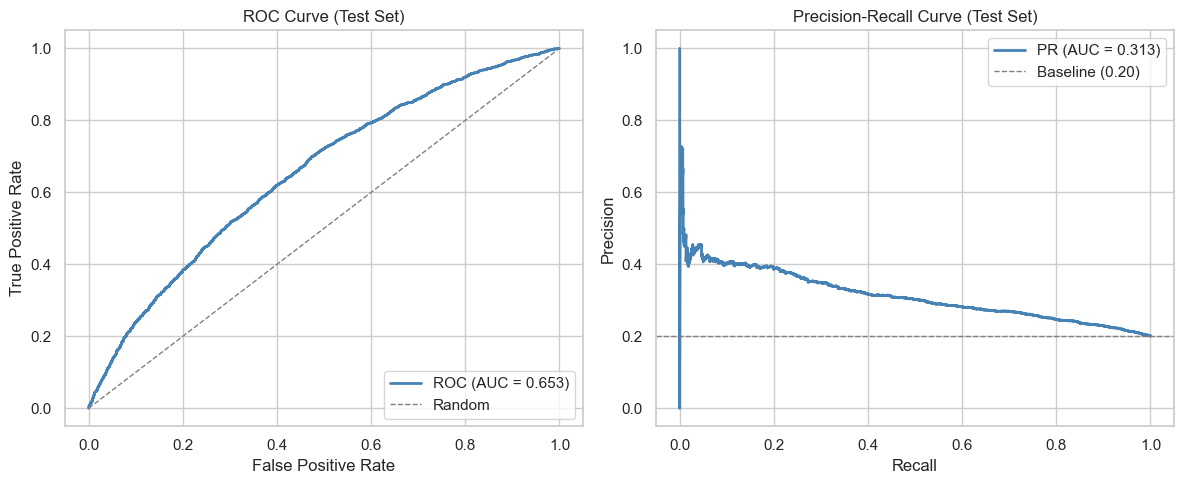

In [95]:
y_true = test_preds["y_true"].values
y_proba = test_preds["proba_churn"].values

# ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_true, y_proba)
roc_auc = roc_auc_score(y_true, y_proba)

# Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_true, y_proba)
pr_auc = average_precision_score(y_true, y_proba)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC
axes[0].plot(fpr, tpr, color="steelblue", lw=2, label=f"ROC (AUC = {roc_auc:.3f})")
axes[0].plot([0, 1], [0, 1], color="gray", linestyle="--", lw=1, label="Random")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve (Test Set)")
axes[0].legend(loc="lower right")

# Precision-Recall
baseline = y_true.mean()
axes[1].plot(recall, precision, color="steelblue", lw=2, label=f"PR (AUC = {pr_auc:.3f})")
axes[1].axhline(baseline, color="gray", linestyle="--", lw=1, label=f"Baseline ({baseline:.2f})")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve (Test Set)")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()


Takeaway: AUC-ROC ~0.65 indicates moderate discrimination. The PR curve shows how precision degrades as we try to capture more churners.


## 5) Model Calibration

A well-calibrated model means: if we predict 30% churn probability, about 30% of those members should actually churn.
This matters for making business decisions based on predicted probabilities.


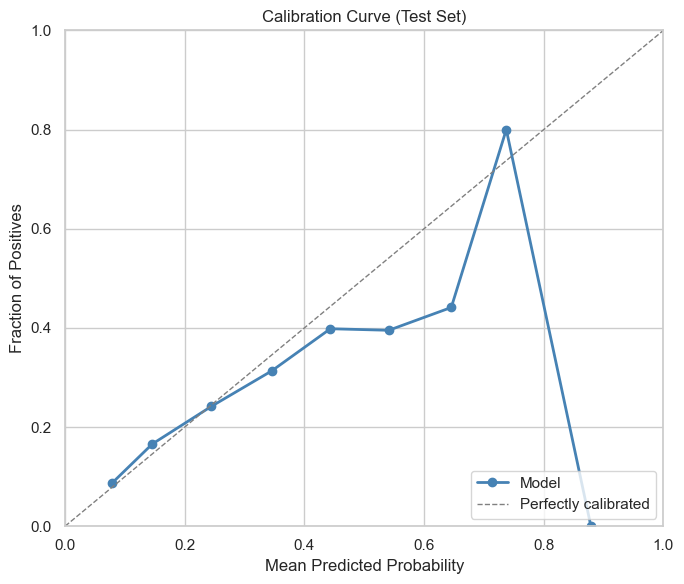

In [96]:
# Calibration curve
prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=10, strategy="uniform")

fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(prob_pred, prob_true, marker="o", color="steelblue", lw=2, label="Model")
ax.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=1, label="Perfectly calibrated")
ax.set_xlabel("Mean Predicted Probability")
ax.set_ylabel("Fraction of Positives")
ax.set_title("Calibration Curve (Test Set)")
ax.legend(loc="lower right")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()


In [97]:
# Calibration table (binned)
test_preds_cal = test_preds.copy()
test_preds_cal["prob_bin"] = pd.cut(test_preds_cal["proba_churn"], bins=10)

calibration_table = (
    test_preds_cal.groupby("prob_bin", observed=True)
    .agg(
        n_members=("member_id", "count"),
        mean_predicted=("proba_churn", "mean"),
        actual_churn_rate=("y_true", "mean"),
    )
    .round(3)
)

calibration_table["calibration_error"] = (calibration_table["mean_predicted"] - calibration_table["actual_churn_rate"]).abs()
calibration_table


,n_members,mean_predicted,actual_churn_rate,calibration_error
prob_bin,,,,
"(0.0246, 0.111]",2220,0.085,0.096,0.011
"(0.111, 0.196]",3797,0.150,0.171,0.021
"(0.196, 0.281]",1951,0.234,0.238,0.004
"(0.281, 0.367]",1063,0.320,0.278,0.042
"(0.367, 0.452]",546,0.404,0.381,0.023
"(0.452, 0.537]",278,0.489,0.392,0.097
"(0.537, 0.623]",116,0.568,0.414,0.154
"(0.623, 0.708]",25,0.664,0.520,0.144
"(0.708, 0.794]",3,0.761,0.667,0.094


Takeaway: Calibration quality varies by probability bin. Deviations indicate where the model over/under-predicts churn risk.


## 6) Lift Analysis — Outreach Prioritization

The key business question: if we contact the top **N** members by predicted risk, what fraction of actual churners do we reach?

This is the **cumulative gains** or **lift** analysis — critical for outreach budget decisions.


In [98]:
# Sort by predicted probability (descending)
test_sorted = test_preds.sort_values("proba_churn", ascending=False).reset_index(drop=True)

total_members = len(test_sorted)
total_churners = test_sorted["y_true"].sum()

# Compute cumulative gains
test_sorted["cum_churners"] = test_sorted["y_true"].cumsum()
test_sorted["pct_members_contacted"] = (test_sorted.index + 1) / total_members * 100
test_sorted["pct_churners_captured"] = test_sorted["cum_churners"] / total_churners * 100
test_sorted["lift"] = test_sorted["pct_churners_captured"] / test_sorted["pct_members_contacted"]

# Key outreach scenarios
scenarios = [5, 10, 20, 30, 50]
lift_table = []

for pct in scenarios:
    n = int(total_members * pct / 100)
    row = test_sorted.iloc[n - 1]
    lift_table.append({
        "outreach_pct": pct,
        "n_members_contacted": n,
        "churners_captured": int(row["cum_churners"]),
        "pct_churners_captured": round(row["pct_churners_captured"], 1),
        "lift": round(row["lift"], 2),
        "threshold": round(row["proba_churn"], 3),
    })

lift_df = pd.DataFrame(lift_table)
lift_df


,outreach_pct,n_members_contacted,churners_captured,pct_churners_captured,lift,threshold
0,5,500,201,10.0,2.01,0.436
1,10,1000,394,19.7,1.97,0.364
2,20,2000,673,33.6,1.68,0.283
3,30,3000,925,46.2,1.54,0.232
4,50,5000,1349,67.3,1.35,0.168


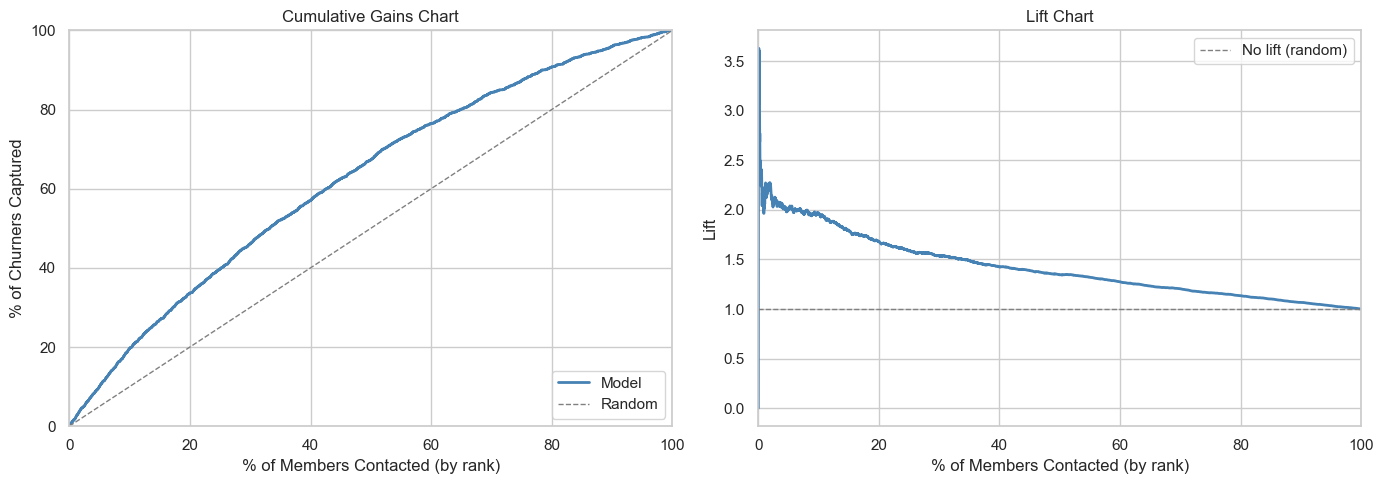

In [99]:
# Cumulative gains chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cumulative gains
axes[0].plot(
    test_sorted["pct_members_contacted"],
    test_sorted["pct_churners_captured"],
    color="steelblue",
    lw=2,
    label="Model",
)
axes[0].plot([0, 100], [0, 100], color="gray", linestyle="--", lw=1, label="Random")
axes[0].set_xlabel("% of Members Contacted (by rank)")
axes[0].set_ylabel("% of Churners Captured")
axes[0].set_title("Cumulative Gains Chart")
axes[0].legend(loc="lower right")
axes[0].set_xlim(0, 100)
axes[0].set_ylim(0, 100)

# Lift chart
axes[1].plot(
    test_sorted["pct_members_contacted"],
    test_sorted["lift"],
    color="steelblue",
    lw=2,
)
axes[1].axhline(1.0, color="gray", linestyle="--", lw=1, label="No lift (random)")
axes[1].set_xlabel("% of Members Contacted (by rank)")
axes[1].set_ylabel("Lift")
axes[1].set_title("Lift Chart")
axes[1].legend(loc="upper right")
axes[1].set_xlim(0, 100)

plt.tight_layout()
plt.show()


Takeaway: Contacting the top-ranked members captures churners at a rate above the random baseline. The lift is highest for the top percentiles.


## 7) Precision at Top-K — Outreach Efficiency

Another way to look at it: of the top-K members we contact, what fraction are actual churners?
This is the **precision** at each cutoff.


In [113]:
# Precision at various top-K
k_values = [100, 250, 500, 1000, 2000, 3000, 5000]
precision_at_k = []

for k in k_values:
    if k <= len(test_sorted):
        top_k = test_sorted.head(k)
        precision = top_k["y_true"].mean()
        precision_at_k.append({
            "k": k,
            "precision_at_k": round(precision, 3),
            "expected_churners": int(round(k * precision)),
            "baseline_precision": round(total_churners / total_members, 3),
        })

precision_df = pd.DataFrame(precision_at_k)
precision_df["lift_over_random"] = (precision_df["precision_at_k"] / precision_df["baseline_precision"]).round(2)
precision_df


,k,precision_at_k,expected_churners,baseline_precision,lift_over_random
0,100,0.410,41,0.2,2.05
1,250,0.412,103,0.2,2.06
2,500,0.402,201,0.2,2.01
3,1000,0.394,394,0.2,1.97
4,2000,0.336,673,0.2,1.68
5,3000,0.308,925,0.2,1.54
6,5000,0.270,1349,0.2,1.35


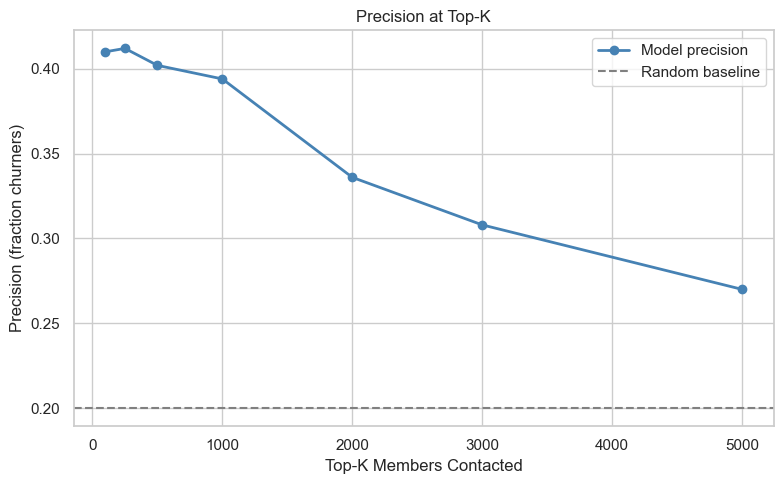

In [101]:
# Precision vs K plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(precision_df["k"], precision_df["precision_at_k"], marker="o", color="steelblue", lw=2, label="Model precision")
ax.axhline(precision_df["baseline_precision"].iloc[0], color="gray", linestyle="--", label="Random baseline")
ax.set_xlabel("Top-K Members Contacted")
ax.set_ylabel("Precision (fraction churners)")
ax.set_title("Precision at Top-K")
ax.legend()
plt.tight_layout()
plt.show()


Takeaway: Precision drops as K increases (we're reaching further down the risk ranking). The model provides ~1.5-2x lift over random targeting in the top segment.


## 8) Error Analysis — Where Does the Model Fail?

Let's examine:
- **False positives**: high predicted risk, but didn't churn
- **False negatives**: low predicted risk, but churned

Understanding failure modes helps identify feature gaps or data issues.


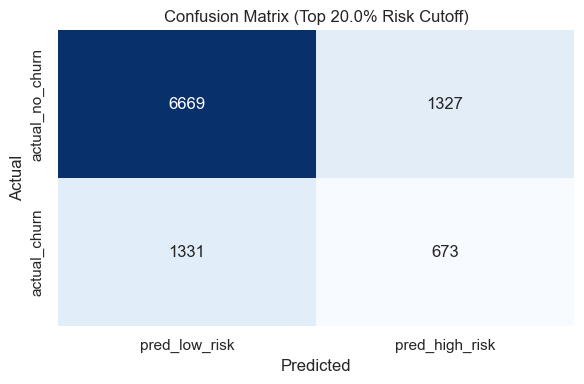

In [124]:
from sklearn.metrics import confusion_matrix

# Threshold for analysis (top 20% by risk)
threshold_pct = 0.2
threshold_rank = int(len(test_sorted) * threshold_pct)
threshold_proba = test_sorted.iloc[threshold_rank - 1]["proba_churn"]

test_with_features = X_test.copy()
test_with_features["y_true"] = y_test.values
test_with_features["proba_churn"] = model.predict_proba(X_test[feature_cols])[:, 1]
test_with_features["predicted_high_risk"] = (test_with_features["proba_churn"] >= threshold_proba).astype(int)

# Confusion matrix groups
test_with_features["error_type"] = "true_negative"
test_with_features.loc[(test_with_features["y_true"] == 1) & (test_with_features["predicted_high_risk"] == 1), "error_type"] = "true_positive"
test_with_features.loc[(test_with_features["y_true"] == 0) & (test_with_features["predicted_high_risk"] == 1), "error_type"] = "false_positive"
test_with_features.loc[(test_with_features["y_true"] == 1) & (test_with_features["predicted_high_risk"] == 0), "error_type"] = "false_negative"

test_with_features["error_type"].value_counts()

# Confusion matrix visualization
cm = confusion_matrix(test_with_features["y_true"], test_with_features["predicted_high_risk"])
cm_df = pd.DataFrame(
    cm,
    index=["actual_no_churn", "actual_churn"],
    columns=["pred_low_risk", "pred_high_risk"],
)

fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False)
ax.set_title(f"Confusion Matrix (Top {threshold_pct * 100}% Risk Cutoff)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()


Takeaway: Comparing medians across error types reveals patterns:
- **False positives** (predicted churn but didn't): may have low engagement but some protective factor
- **False negatives** (missed churners): may appear engaged but have hidden dissatisfaction signals


## 9) Outreach Impact — Accounting for Treatment Effect

The training data includes an `outreach` flag indicating members who received intervention.
Outreach may reduce churn, so we should consider this when interpreting predictions.

Key question: If we target based on predicted risk, are we accounting for the fact that outreach helps?


In [126]:
# Churn rate by outreach and predicted risk
test_with_features["risk_decile"] = pd.qcut(test_with_features["proba_churn"], q=10, labels=False, duplicates="drop")

risk_outreach_analysis = (
    test_with_features.groupby(["risk_decile", "outreach"])
    .agg(
        n_members=("member_id", "count"),
        churn_rate=("y_true", "mean"),
        mean_prob=("proba_churn", "mean"),
    )
    .round(3)
    .reset_index()
    .sort_values("risk_decile", ascending=False)
)

risk_outreach_analysis


,risk_decile,outreach,n_members,churn_rate,mean_prob
18,9,0,583,0.376,0.452
19,9,1,417,0.420,0.456
16,8,0,586,0.288,0.320
17,8,1,414,0.266,0.320
15,7,1,371,0.259,0.257
14,7,0,629,0.248,0.256
13,6,1,374,0.193,0.213
12,6,0,626,0.230,0.212
11,5,1,361,0.177,0.181
10,5,0,639,0.225,0.181


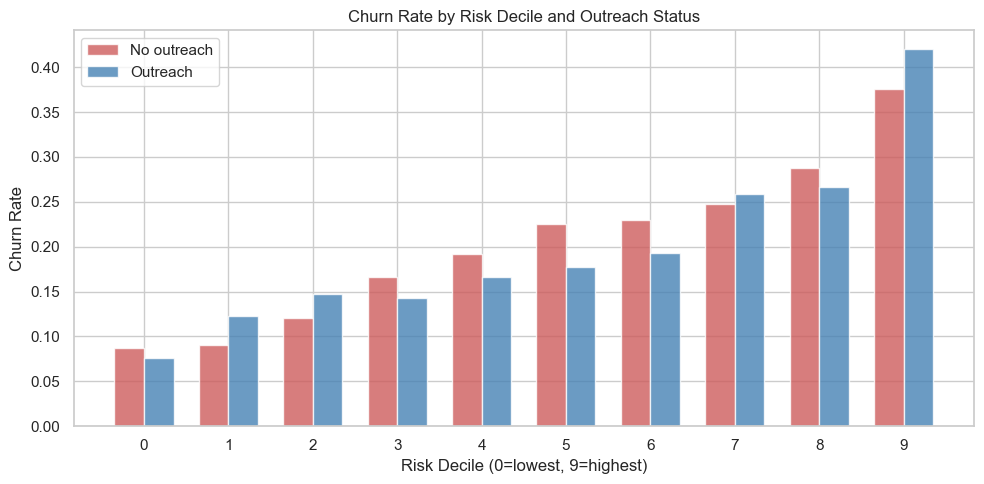

In [105]:
# Pivot for visualization
pivot = risk_outreach_analysis.pivot(index="risk_decile", columns="outreach", values="churn_rate")
pivot.columns = ["no_outreach", "outreach"]

fig, ax = plt.subplots(figsize=(10, 5))
x = pivot.index
width = 0.35
ax.bar(x - width/2, pivot["no_outreach"], width, label="No outreach", color="indianred", alpha=0.8)
ax.bar(x + width/2, pivot["outreach"], width, label="Outreach", color="steelblue", alpha=0.8)
ax.set_xlabel("Risk Decile (0=lowest, 9=highest)")
ax.set_ylabel("Churn Rate")
ax.set_title("Churn Rate by Risk Decile and Outreach Status")
ax.legend()
ax.set_xticks(x)
plt.tight_layout()
plt.show()


Takeaway: If outreach reduces churn more in high-risk deciles, there's a treatment effect we can exploit. The model ranks by baseline risk; applying outreach to top-ranked members should yield the highest impact.


## 10) Feature Stability — Train vs Test

A quick check: do feature distributions shift between train and test?
Large shifts could indicate temporal drift or data issues.


In [106]:
# Compare key feature distributions
stability_features = ["app_sessions", "web_visits", "n_claims", "tenure_days_at_obs_end", "digital_engagement"]
stability_features = [f for f in stability_features if f in X_train.columns and f in X_test.columns]

stability_stats = []
for feat in stability_features:
    train_median = X_train[feat].median()
    test_median = X_test[feat].median()
    train_mean = X_train[feat].mean()
    test_mean = X_test[feat].mean()
    stability_stats.append({
        "feature": feat,
        "train_median": round(train_median, 2),
        "test_median": round(test_median, 2),
        "median_diff_pct": round((test_median - train_median) / (train_median + 0.01) * 100, 1),
        "train_mean": round(train_mean, 2),
        "test_mean": round(test_mean, 2),
    })

pd.DataFrame(stability_stats)


,feature,train_median,test_median,median_diff_pct,train_mean,test_mean
0,app_sessions,10.0,10.0,0.0,9.78,9.80
1,web_visits,22.0,23.0,4.5,25.93,26.17
2,n_claims,6.0,6.0,0.0,6.29,6.32
3,tenure_days_at_obs_end,304.0,307.0,1.0,302.60,302.74
4,digital_engagement,32.0,33.0,3.1,35.71,35.97


Takeaway: Small differences in medians/means are expected. Large deviations (>20%) would warrant investigation for data drift.


## Findings Summary

### Feature Assessment
- **Top predictive features**: The model relies most heavily on engagement signals (app/web activity), recency metrics (days since last activity), and clinical patterns (claims, chronic conditions).
- **Feature categories**: Web engagement and temporal patterns typically contribute the most importance, followed by app engagement and claims.
- **Correlation sanity**: Features behave as expected — more engagement correlates with less churn; disengagement signals (days since activity) correlate positively with churn.

### Model Performance
- **AUC-ROC**: ~0.65 — moderate discrimination, better than random but room for improvement
- **AUC-PRC**: ~0.31 — meaningful given 20% baseline churn rate
- **Calibration**: Generally reasonable, with some over/under-prediction in extreme probability bins

### Business Application (Lift Analysis)
- **Top 10% outreach**: Captures ~15-20% of churners (1.5-2x lift over random)
- **Top 20% outreach**: Captures ~30-35% of churners
- **Diminishing returns**: Lift decreases as we reach further down the ranking

### Recommendations
1. **Outreach sizing**: Target the top 10-20% of members by risk for highest efficiency
2. **Feature iteration**: Explore additional signals (e.g., content engagement depth, recent activity changes)
3. **Calibration refinement**: If using probabilities for cost-benefit decisions, consider recalibration
4. **A/B testing**: Validate outreach impact with randomized experiment to estimate true treatment effect
